In [1]:
# Importing our libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# I. LOADING DATASET

I got this dataset by scraping Airbnb website using web scraping app called Octoparse.

In [2]:
# Load the dataset

df = pd.read_csv('airbnb bali-raw dataset.csv') 
df.head()

,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m
0,"NEW Private Luxe Villa, Jungle View-Pool-Koi Pond",https://www.airbnb.com/rooms/49443276?adults=2...,NaN,Entire villa in Kecamatan Ubud,2 guests,1 bedroom,1 bed,1 bath,Pool,Wifi,Air conditioning,Kitchen,5.00,(13 reviews),$42,$225 total
1,"-75% New Luxe Villa C, Private Pool/Jungle Views",https://www.airbnb.com/rooms/50444504?adults=2...,NaN,Entire villa in Kecamatan Ubud,2 guests,1 bedroom,0 beds,1 bath,Pool,Wifi,Air conditioning,Kitchen,5.00,(9 reviews),$38,$205 total
2,55%OFF|Lasamana Exotic Hideaway W/ Rice Field ...,https://www.airbnb.com/rooms/44411077?adults=2...,SUPERHOST,Private room in Kecamatan Ubud,2 guests,1 bedroom,1 bed,1 private bath,Pool,Wifi,Air conditioning,Kitchen,4.93,(28 reviews),$47,$233 total
3,-70%- Chic 2BR private villa with endless rice...,https://www.airbnb.com/rooms/43271847?adults=2...,NaN,Entire villa in Kecamatan Ubud,6 guests,2 bedrooms,2 beds,2 baths,Pool,Wifi,Air conditioning,Kitchen,4.90,(52 reviews),$215,"$1,075 total"
4,Magical Treehouse with Jungle Pool above the R...,https://www.airbnb.com/rooms/plus/792724?adult...,PLUS,Treehouse in Ubud,4 guests,2 bedrooms,3 beds,2 baths,Pool,Wifi,Air conditioning,Kitchen,4.77,(439 reviews),$280,"$1,399 total"


In [3]:
df.shape


# This dataset contains 300 rows and 16 columns

(300, 16)

####    labels explanation:

- Title: Accomodation's name and/or general description
- listing_url: url for each accommodation
- service_level: null, Superhost, or Plus (Superhost is of higher rank than null, Plus is of higher rank than Superhost)
- accom_type: type of accommodation + area/neighborhood
- max_guest: maximum number of guests that can stay in each accommodation at a time
- no_bedroom: total number of bedrooms in each accommodation
- no_bed: total number of beds
- no_bathroom: total number of bathrooms
- _3c0zz14,_3c0zz15, _3c0zz16, _3c0zz17: 4 main amenities as specified in the listing
- rating: rating score (1-5)
- no_review: total number of customers who have given their review
- price: price/night in USD
- _tt122m: total price in USD (unused)

At a glance, our dataset looks pretty neat and quite easy to understand. However, neat according to human eyes does not necessarily mean neat or readable according to Python. As we can see, some labels are categorical in nature, while the others are numerical. Therefore, the very first thing we need to do after loading our dataset is to check the data types for each label.

# II. DATA CLEANING

## 2.1 Identifying data types

In [4]:
# Check data type of each label

df.dtypes

Title             object
listing_url       object
service_level     object
accom_type        object
max_guest         object
no_bedroom        object
no_bed            object
no_bathroom       object
_3c0zz14          object
_3c0zz15          object
_3c0zz16          object
_3c0zz17          object
rating           float64
no_review         object
price             object
_tt122m           object
dtype: object

It is apparent that the only truly numerical column is 'rating' . However, these columns also need to be numerical in order to be usable:
- max_guest
- no_bedroom       
- no_bed          
- no_bathroom   
- no_review
- price

## 2.2 Dealing with inappropriate values

We need to check whether our dataset contains incorrect values, such as categorical values in numerical variables and slightly different naming for supposedly identical categorical values.

### 2.2.1 Numerical variables

#### 2.2.1.1 Checking for unusual value

In [5]:
df['max_guest'].unique() 

# no unusual value

array(['2 guests', '6 guests', '4 guests', '3 guests', '16 guests',
       '5 guests', '14 guests', '7 guests', '10 guests', '8 guests',
       '12 guests'], dtype=object)

In [6]:
df['no_bedroom'].unique() 

# studio means one room, 28 rooms doesnt sound right but we will get back to it later

array(['1 bedroom', '2 bedrooms', '1 private bedroom', '3 bedrooms',
       'Studio', '5 bedrooms', '6 bedrooms', '4 bedrooms', '7 bedrooms',
       '28 bedrooms'], dtype=object)

In [7]:
df[df['no_bedroom'] == '28 bedrooms'] 


# Luckily, we have the url for this particular listing so we can do some investigation
# Since it is just a regular hotel room, we can conclude that the number of room is 1

,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m
280,Adiwana Bisma,https://www.airbnb.com/rooms/51990429?adults=2...,NaN,Hotel room in Kecamatan Ubud,2 guests,28 bedrooms,1 bed,1 private bath,Pool,Wifi,Air conditioning,NaN,NaN,NaN,$52,$260 total


In [8]:
df['no_bed'].unique() 

#'0 beds' looks suspicious

array(['1 bed', '0 beds', '2 beds', '3 beds', '1 private bath', '1 bath',
       '6 beds', '7 beds', '9 beds', '5 beds', '4 beds'], dtype=object)

In [9]:
df[df['no_bed'] == '0 beds'].head()


# It is pretty unlikely that hotels/villas have no bed (unless if they offer 'unique experience'). Therefore, in this case we would just make
# an educated guess where if the number of bed is 0, we would replace it with the values on 'no_bedroom'

,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m
1,"-75% New Luxe Villa C, Private Pool/Jungle Views",https://www.airbnb.com/rooms/50444504?adults=2...,NaN,Entire villa in Kecamatan Ubud,2 guests,1 bedroom,0 beds,1 bath,Pool,Wifi,Air conditioning,Kitchen,5.00,(9 reviews),$38,$205 total
18,Unique wooden house in Balinese Lumbung Style,https://www.airbnb.com/rooms/42480717?adults=2...,NaN,Entire villa in Ubud,2 guests,1 bedroom,0 beds,1 bath,Wifi,Air conditioning,Kitchen,NaN,5.00,(5 reviews),$30,$148 total
57,"Exclusive Villa, for Couples Looking To Relax",https://www.airbnb.com/rooms/40773716?adults=2...,SUPERHOST,Private room in Kecamatan Ubud,2 guests,1 bedroom,0 beds,1 private bath,Pool,Wifi,Air conditioning,NaN,5.00,(9 reviews),$69,$371 total
105,Beautiful Room Near Ubud Market - Large Pool,https://www.airbnb.com/rooms/17592869?adults=2...,SUPERHOST,Hotel room in Ubud,2 guests,1 bedroom,0 beds,1 private bath,Wifi,Air conditioning,NaN,NaN,4.62,(182 reviews),$23,$113 total
132,Villa Amrita Ubud Bali One Bedroom,https://www.airbnb.com/rooms/813651?adults=2&c...,SUPERHOST,Entire villa in Tegallalang,7 guests,1 bedroom,0 beds,2 baths,Pool,Wifi,Air conditioning,Kitchen,4.93,(67 reviews),$143,$713 total


In [10]:
df['no_bathroom'].unique() 

# unusual value 'Kitchen' in 'no_bathroom'

array(['1 bath', '1 private bath', '2 baths', '2 shared baths',
       '2.5 baths', '1.5 baths', nan, '3 baths', '1.5 shared baths',
       '1 shared bath', '5.5 baths', '6 baths', '3.5 baths', '4 baths',
       'Kitchen', '5 baths', '7 baths'], dtype=object)

In [11]:
df[df['no_bathroom'] == 'Kitchen']

# Because the two listings that have Kitchen in 'no_bathroom' have one bedroom, we would just assume that the number of bathroom is also one.



,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m
169,Paradise River side Bungalow 2,https://www.airbnb.com/rooms/47837699?adults=2...,NaN,Room in boutique hotel in Kecamatan Ubud,2 guests,1 bedroom,1 bed,Kitchen,Pool,Wifi,Air conditioning,Kitchen,5.0,(3 reviews),$17,$86 total
214,Private Pool Villa @ Uma Jala Villa Ubud,https://www.airbnb.com/rooms/50879242?adults=2...,NaN,Entire villa in Kecamatan Ubud,2 guests,1 bedroom,1 bath,Kitchen,Pool,Wifi,Air conditioning,Kitchen,NaN,NaN,$40,$200 total


In [12]:
df['rating'].unique() 

#no unusual value

array([5.  , 4.93, 4.9 , 4.77,  nan, 4.92, 4.71, 4.88, 4.76, 4.78, 4.68,
       4.91, 4.73, 4.79, 4.62, 4.86, 4.96, 4.85, 4.2 , 4.87, 4.83, 4.67,
       4.95, 4.94, 4.98, 4.74, 4.8 , 4.99, 4.81, 4.45, 4.89, 4.75, 4.59,
       4.7 , 4.6 , 4.72, 4.24, 4.84, 4.65, 4.64, 4.69, 4.19, 4.82, 3.71,
       4.97, 4.61, 4.55, 4.53, 4.56, 3.92, 4.5 , 4.57])

In [13]:
df['no_review'].unique() 

#no unusual value

array(['(13 reviews)', '(9 reviews)', '(28 reviews)', '(52 reviews)',
       '(439 reviews)', '(47 reviews)', nan, '(36 reviews)',
       '(445 reviews)', '(181 reviews)', '(49 reviews)', '(268 reviews)',
       '(95 reviews)', '(99 reviews)', '(8 reviews)', '(128 reviews)',
       '(22 reviews)', '(271 reviews)', '(5 reviews)', '(19 reviews)',
       '(312 reviews)', '(66 reviews)', '(29 reviews)', '(3 reviews)',
       '(7 reviews)', '(20 reviews)', '(14 reviews)', '(117 reviews)',
       '(10 reviews)', '(126 reviews)', '(67 reviews)', '(18 reviews)',
       '(138 reviews)', '(113 reviews)', '(338 reviews)', '(63 reviews)',
       '(31 reviews)', '(165 reviews)', '(27 reviews)', '(143 reviews)',
       '(12 reviews)', '(69 reviews)', '(85 reviews)', '(64 reviews)',
       '(38 reviews)', '(140 reviews)', '(98 reviews)', '(178 reviews)',
       '(74 reviews)', '(105 reviews)', '(337 reviews)', '(91 reviews)',
       '(16 reviews)', '(73 reviews)', '(15 reviews)', '(108 reviews)',
   

In [14]:
df['price'].unique() 

#no unusual value

array(['$42', '$38', '$47', '$215', '$280', '$49', '$105', '$354', '$32',
       '$80', '$16', '$294', '$12', '$119', '$66', '$537', '$107', '$176',
       '$30', '$63', '$120', '$41', '$24', '$144', '$56', '$60', '$81',
       '$89', '$250', '$68', '$35', '$126', '$295', '$88', '$174', '$154',
       '$207', '$108', '$73', '$100', '$76', '$134', '$48', '$39', '$69',
       '$84', '$45', '$160', '$33', '$17', '$129', '$40', '$23', '$55',
       '$72', '$28', '$128', '$82', '$54', '$19', '$26', '$102', '$175',
       '$70', '$90', '$64', '$36', '$161', '$121', '$198', '$256', '$75',
       '$200', '$193', '$59', '$34', '$25', '$112', '$101', '$202', '$14',
       '$768', '$399', '$95', '$62', '$13', '$91', '$143', '$20', '$132',
       '$149', '$172', '$195', '$206', '$127', '$273', '$58', '$83',
       '$50', '$224', '$531', '$155', '$96', '$43', '$204', '$118',
       '$480', '$11', '$168', '$413', '$151', '$29', '$167', '$342',
       '$15', '$22', '$650', '$472', '$125', '$77', '$15

#### 2.2.1.2. Inputting the correct value

Let's correct the wrong values:

In [15]:
# Change value of 'Studio' to '1 bedroom'

for i in range(len(df)):
    if df.iloc[i,5] == 'Studio':
        df.iloc[i,5] = '1 bedroom'
    df

In [16]:
# Change value of 'Kitchen' to '1 bath'

for i in range(len(df)):
    if df.iloc[i,7] == 'Kitchen':
        df.iloc[i,7] = '1 bath'
    df

In [17]:
df['no_bedroom'].unique() # No more 'Studio'

array(['1 bedroom', '2 bedrooms', '1 private bedroom', '3 bedrooms',
       '5 bedrooms', '6 bedrooms', '4 bedrooms', '7 bedrooms',
       '28 bedrooms'], dtype=object)

In [18]:
df['no_bathroom'].unique() # No more 'kitchen'

array(['1 bath', '1 private bath', '2 baths', '2 shared baths',
       '2.5 baths', '1.5 baths', nan, '3 baths', '1.5 shared baths',
       '1 shared bath', '5.5 baths', '6 baths', '3.5 baths', '4 baths',
       '5 baths', '7 baths'], dtype=object)

#### 2.2.1.3 Changing data types

In [19]:
#Change from string to float:

df['max_guest'] = df['max_guest'].str.split(' ').str[0]
df['max_guest'] = df['max_guest'].astype(float)

df['no_bedroom'] = df['no_bedroom'].str.split(' ').str[0]
df['no_bedroom'] = df['no_bedroom'].astype(float)

df['no_bed'] = df['no_bed'].str.split(' ').str[0]
df['no_bed'] = df['no_bed'].astype(float)

df['no_bathroom'] = df['no_bathroom'].str.split(' ').str[0]
df['no_bathroom'] = df['no_bathroom'].astype(float)

df['no_review'] = df['no_review'].str.replace('(' or ')', '')
df['no_review'] = df['no_review'].str.split(' ').str[0]
df['no_review'] = df['no_review'].astype(float)

df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].astype(float)

In [20]:
# we should not forget that some values in 'no_bedroom' and 'no_bed' need some changing

df.loc[280, 'no_bedroom'] = 1 # change 28 bedrooms to 1

for i in range(len(df)):
    if df.iloc[i, 6] == 0:
        df.iloc[i, 6] = df.iloc[i, 5]
        
df.head()

,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m
0,"NEW Private Luxe Villa, Jungle View-Pool-Koi Pond",https://www.airbnb.com/rooms/49443276?adults=2...,NaN,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,13.0,42.0,$225 total
1,"-75% New Luxe Villa C, Private Pool/Jungle Views",https://www.airbnb.com/rooms/50444504?adults=2...,NaN,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,9.0,38.0,$205 total
2,55%OFF|Lasamana Exotic Hideaway W/ Rice Field ...,https://www.airbnb.com/rooms/44411077?adults=2...,SUPERHOST,Private room in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,4.93,28.0,47.0,$233 total
3,-70%- Chic 2BR private villa with endless rice...,https://www.airbnb.com/rooms/43271847?adults=2...,NaN,Entire villa in Kecamatan Ubud,6.0,2.0,2.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.90,52.0,215.0,"$1,075 total"
4,Magical Treehouse with Jungle Pool above the R...,https://www.airbnb.com/rooms/plus/792724?adult...,PLUS,Treehouse in Ubud,4.0,2.0,3.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.77,439.0,280.0,"$1,399 total"


In [21]:
df.describe()

,max_guest,no_bedroom,no_bed,no_bathroom,rating,no_review,price
count,300.000000,300.000000,300.000000,297.000000,227.000000,227.000000,300.000000
mean,2.983333,1.396667,1.523333,1.489899,4.821233,83.361233,107.043333
std,2.063310,0.876670,1.143305,0.939864,0.181406,99.218771,125.731205
min,2.000000,1.000000,1.000000,1.000000,3.710000,3.000000,11.000000
25%,2.000000,1.000000,1.000000,1.000000,4.735000,13.500000,36.000000
50%,2.000000,1.000000,1.000000,1.000000,4.860000,44.000000,63.500000
75%,4.000000,2.000000,2.000000,2.000000,4.945000,127.000000,126.000000
max,16.000000,7.000000,9.000000,7.000000,5.000000,582.000000,768.000000


### 2.2.2. Categorical variables

#### 2.2.2.1 Checking for unusual values

In [22]:
df['service_level'].unique() #no unusual value

array([nan, 'SUPERHOST', 'PLUS'], dtype=object)

In [23]:
# The 'accom_type' label actually contains 2 kinds of information, the accommodation type and the area. 
# Therefore, we want to split the label into 2 different labels ('type' and 'area') 
# first before checking for unusual values:

df[['type','area']] = df['accom_type'].str.rsplit(' in ', n = 1, expand = True)
df.head()

,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m,type,area
0,"NEW Private Luxe Villa, Jungle View-Pool-Koi Pond",https://www.airbnb.com/rooms/49443276?adults=2...,NaN,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,13.0,42.0,$225 total,Entire villa,Kecamatan Ubud
1,"-75% New Luxe Villa C, Private Pool/Jungle Views",https://www.airbnb.com/rooms/50444504?adults=2...,NaN,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,9.0,38.0,$205 total,Entire villa,Kecamatan Ubud
2,55%OFF|Lasamana Exotic Hideaway W/ Rice Field ...,https://www.airbnb.com/rooms/44411077?adults=2...,SUPERHOST,Private room in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,4.93,28.0,47.0,$233 total,Private room,Kecamatan Ubud
3,-70%- Chic 2BR private villa with endless rice...,https://www.airbnb.com/rooms/43271847?adults=2...,NaN,Entire villa in Kecamatan Ubud,6.0,2.0,2.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.90,52.0,215.0,"$1,075 total",Entire villa,Kecamatan Ubud
4,Magical Treehouse with Jungle Pool above the R...,https://www.airbnb.com/rooms/plus/792724?adult...,PLUS,Treehouse in Ubud,4.0,2.0,3.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.77,439.0,280.0,"$1,399 total",Treehouse,Ubud


In [24]:
print(df['type'].unique()) #no unusual value

['Entire villa' 'Private room' 'Treehouse' 'Shared room'
 'Entire residential home' 'Entire rental unit' 'Room in boutique hotel'
 'Tiny house' 'Hotel room' 'Dome house' 'Entire cottage' 'Resort room'
 'Entire bungalow' 'Entire serviced apartment' 'Hut' 'Entire townhouse'
 'Entire place' 'Entire guesthouse' 'Entire loft' 'Entire cabin']


In [25]:
print(df['area'].unique()) 

# there are some different names for some values that are actually identical

['Kecamatan Ubud' 'Ubud' 'Payangan' 'Gianyar' 'Ubud, Gianyar'
 'Ubud , Gianyar' 'Bali' 'Kecamatan Tegallalang' 'Tegallalang'
 'Kabupaten Gianyar' 'Sukawati' 'Tegalalang' 'Banjar Kutuh kaja'
 'Tampaksiring' 'Kecamatan Sukawati' 'Ubud Bali' 'Kecamatan Gianyar'
 'Blahbatuh']


#### 2.2.2.2. Inputting the correct values

In [26]:
# These labels represent the 4 main amenities
# At this point, we want to merge these labels so as to make their values easier to manipulate for feature engineering later

print(df['_3c0zz14'].unique())
print(df['_3c0zz15'].unique())
print(df['_3c0zz16'].unique())
print(df['_3c0zz17'].unique())

['Pool' 'Wifi' nan]
['Wifi' 'Air conditioning' nan 'Kitchen']
['Air conditioning' nan 'Kitchen']
['Kitchen' nan]


In [27]:
# Turns out we can not merge string values with nulls
# Therefore, we fill nulls with the string 'none'

df['_3c0zz14'].fillna('none', inplace = True)
df['_3c0zz15'].fillna('none', inplace = True)
df['_3c0zz16'].fillna('none', inplace = True)
df['_3c0zz17'].fillna('none', inplace = True)

In [28]:
#merge amenities
df['amenities'] = df[['_3c0zz14','_3c0zz15','_3c0zz16','_3c0zz17']].agg(','.join, axis = 1)

In [29]:
# Correct area names

for i in range(len(df)):
    if df.iloc[i, 17] == 'Kecamatan Ubud' or df.iloc[i, 17] == 'Ubud Bali' or df.iloc[i, 17] == 'Bali':
        df.iloc[i, 17] = 'Ubud'
    if df.iloc[i, 17] == 'Ubud, Gianyar' or df.iloc[i, 17] == 'Ubud , Gianyar'or df.iloc[i, 17] == 'Kabupaten Gianyar' or df.iloc[i, 17] == 'Kecamatan Gianyar':
        df.iloc[i, 17] = 'Gianyar'
    if df.iloc[i, 17] == 'Kecamatan Tegallalang' or df.iloc[i, 17] == 'Tegallalang':
        df.iloc[i, 17] = 'Tegalalang'
        
df.head()

,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m,type,area,amenities
0,"NEW Private Luxe Villa, Jungle View-Pool-Koi Pond",https://www.airbnb.com/rooms/49443276?adults=2...,NaN,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,13.0,42.0,$225 total,Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
1,"-75% New Luxe Villa C, Private Pool/Jungle Views",https://www.airbnb.com/rooms/50444504?adults=2...,NaN,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,9.0,38.0,$205 total,Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
2,55%OFF|Lasamana Exotic Hideaway W/ Rice Field ...,https://www.airbnb.com/rooms/44411077?adults=2...,SUPERHOST,Private room in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,4.93,28.0,47.0,$233 total,Private room,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
3,-70%- Chic 2BR private villa with endless rice...,https://www.airbnb.com/rooms/43271847?adults=2...,NaN,Entire villa in Kecamatan Ubud,6.0,2.0,2.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.90,52.0,215.0,"$1,075 total",Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
4,Magical Treehouse with Jungle Pool above the R...,https://www.airbnb.com/rooms/plus/792724?adult...,PLUS,Treehouse in Ubud,4.0,2.0,3.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.77,439.0,280.0,"$1,399 total",Treehouse,Ubud,"Pool,Wifi,Air conditioning,Kitchen"


In [30]:
df['type'].unique()

array(['Entire villa', 'Private room', 'Treehouse', 'Shared room',
       'Entire residential home', 'Entire rental unit',
       'Room in boutique hotel', 'Tiny house', 'Hotel room', 'Dome house',
       'Entire cottage', 'Resort room', 'Entire bungalow',
       'Entire serviced apartment', 'Hut', 'Entire townhouse',
       'Entire place', 'Entire guesthouse', 'Entire loft', 'Entire cabin'],
      dtype=object)

In [31]:
df['area'].unique()

array(['Ubud', 'Payangan', 'Gianyar', 'Tegalalang', 'Sukawati',
       'Banjar Kutuh kaja', 'Tampaksiring', 'Kecamatan Sukawati',
       'Blahbatuh'], dtype=object)

In [32]:
df.dtypes # all the labels that are independent variables candidates are in the right types

Title             object
listing_url       object
service_level     object
accom_type        object
max_guest        float64
no_bedroom       float64
no_bed           float64
no_bathroom      float64
_3c0zz14          object
_3c0zz15          object
_3c0zz16          object
_3c0zz17          object
rating           float64
no_review        float64
price            float64
_tt122m           object
type              object
area              object
amenities         object
dtype: object

### 2.2.3. Dealing with remaining nulls

#### 2.2.3.1. Checking for nulls

#### It is always a good idea to use heatmap to show us the visual representation of nulls in our dataset

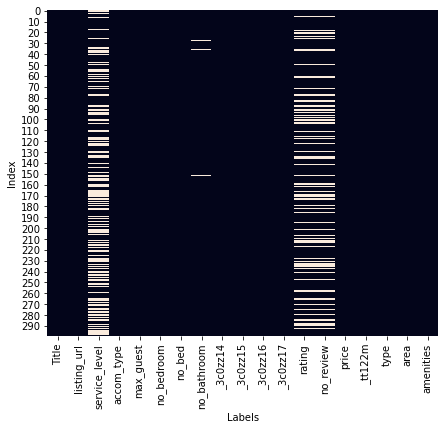

In [33]:
#Heatmap

plt.figure(figsize=(7, 6))
sns.heatmap(df.isnull(), cbar=False)

plt.xlabel('Labels')
plt.ylabel('Index')
plt.show()

#beige color indicates nulls

In [34]:
df.isnull().mean() * 100 

#percentages of empty values in each column

Title             0.000000
listing_url       0.000000
service_level    41.000000
accom_type        0.000000
max_guest         0.000000
no_bedroom        0.000000
no_bed            0.000000
no_bathroom       1.000000
_3c0zz14          0.000000
_3c0zz15          0.000000
_3c0zz16          0.000000
_3c0zz17          0.000000
rating           24.333333
no_review        24.333333
price             0.000000
_tt122m           0.000000
type              0.000000
area              0.000000
amenities         0.000000
dtype: float64

#### 2.2.3.2. Filling nulls with appropriate values

So far, we are left with 'service_level', 'rating', and 'no_review' that have empty values. 

Deleting rows that contain nulls is not always wise as we may risk losing important information or creating biased models. Since there is no cookie-cutter method to deal with nulls, nulls in each column have to be treated according to their specific situations.

In [35]:
# filling the nulls in 'service_level' with 'Regular' will make handling this label easier later:

df['service_level'].fillna('REGULAR', inplace = True)

In [36]:
print(df['rating'].median())
print(df['rating'].mean())

# turns out the median and mean have similar values, but we will use median as it is less impacted by outliers

4.86
4.821233480176211


In [37]:
df['rating'].fillna(df['rating'].median(), inplace = True) 

# fill nulls with median

In [38]:
df['no_review'].fillna(0, inplace = True) 
df['no_review'] = df['no_review'].astype(int)

# In this label, nulls simply mean that these accommodations have not received any review
# Therefore, we fill these nulls with zeros

In [39]:
df['no_bathroom'].fillna(1, inplace = True)

# fill nulls with ones

In [40]:
df.head()

,Title,listing_url,service_level,accom_type,max_guest,no_bedroom,no_bed,no_bathroom,_3c0zz14,_3c0zz15,_3c0zz16,_3c0zz17,rating,no_review,price,_tt122m,type,area,amenities
0,"NEW Private Luxe Villa, Jungle View-Pool-Koi Pond",https://www.airbnb.com/rooms/49443276?adults=2...,REGULAR,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,13,42.0,$225 total,Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
1,"-75% New Luxe Villa C, Private Pool/Jungle Views",https://www.airbnb.com/rooms/50444504?adults=2...,REGULAR,Entire villa in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,5.00,9,38.0,$205 total,Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
2,55%OFF|Lasamana Exotic Hideaway W/ Rice Field ...,https://www.airbnb.com/rooms/44411077?adults=2...,SUPERHOST,Private room in Kecamatan Ubud,2.0,1.0,1.0,1.0,Pool,Wifi,Air conditioning,Kitchen,4.93,28,47.0,$233 total,Private room,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
3,-70%- Chic 2BR private villa with endless rice...,https://www.airbnb.com/rooms/43271847?adults=2...,REGULAR,Entire villa in Kecamatan Ubud,6.0,2.0,2.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.90,52,215.0,"$1,075 total",Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
4,Magical Treehouse with Jungle Pool above the R...,https://www.airbnb.com/rooms/plus/792724?adult...,PLUS,Treehouse in Ubud,4.0,2.0,3.0,2.0,Pool,Wifi,Air conditioning,Kitchen,4.77,439,280.0,"$1,399 total",Treehouse,Ubud,"Pool,Wifi,Air conditioning,Kitchen"


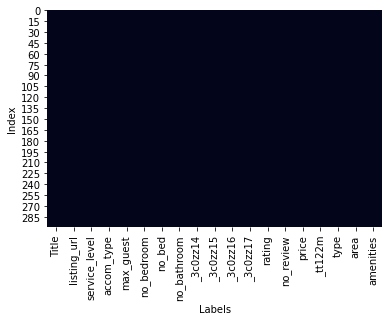

In [41]:
sns.heatmap(df.isnull(), cbar=False) # no more null!

plt.xlabel('Labels')
plt.ylabel('Index')
plt.show()

In [42]:
# At this stage, we decided that we want to drop some labels that we already know that we will not use
# However, right before our model building step, it is highly likely that we will remove some more labels

dd = df.drop(labels = ['Title', 'listing_url', 'accom_type', '_3c0zz14', '_3c0zz15', '_3c0zz16', '_3c0zz17', '_tt122m'], axis = 1)

dd.head() # new dataframe after first label removal

,service_level,max_guest,no_bedroom,no_bed,no_bathroom,rating,no_review,price,type,area,amenities
0,REGULAR,2.0,1.0,1.0,1.0,5.00,13,42.0,Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
1,REGULAR,2.0,1.0,1.0,1.0,5.00,9,38.0,Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
2,SUPERHOST,2.0,1.0,1.0,1.0,4.93,28,47.0,Private room,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
3,REGULAR,6.0,2.0,2.0,2.0,4.90,52,215.0,Entire villa,Ubud,"Pool,Wifi,Air conditioning,Kitchen"
4,PLUS,4.0,2.0,3.0,2.0,4.77,439,280.0,Treehouse,Ubud,"Pool,Wifi,Air conditioning,Kitchen"


### And finally, we got our data cleansed. Congrats!

In [43]:
dd.to_csv('airbnb bali-cleansed dataset.csv', index = False)